In [6]:
# ==========================================
# 1. 라이브러리 임포트 & 설정
# ==========================================
import sys
import os
from google.colab import drive

if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

PROJECT_PATH = '/content/drive/MyDrive/DL_Project'
os.chdir(PROJECT_PATH)
sys.path.append(PROJECT_PATH)

try:
    from common.np import *
    from common.time_layers import TimeEmbedding, TimeLSTM, TimeDropout
    from common.layers import Affine, SoftmaxWithLoss, Sigmoid, Dropout
    from common.optimizer import Adam
    from utils import extract_utterances
    import pandas as pd
    from collections import Counter
    print("✅ 라이브러리 로드 성공. 사용 모듈:", np.__name__)
except ImportError as e:
    print(f"❌ 라이브러리 로드 실패: {e}")



def load_vocab(train_csv, max_vocab=4000):
    df = pd.read_csv(train_csv)
    words = []
    print("⏳ Vocab 생성 중...")
    for _, row in df.iterrows():
        try:
            utts = extract_utterances(row['filename'], ['CHI'])
            text = " ".join([u.clean_text for u in utts]).lower()
            words.extend(text.split())
        except: continue
    counter = Counter(words)
    most_common = counter.most_common(max_vocab)
    vocab = {'<pad>': 0, '<unk>': 1}
    for i, (w, _) in enumerate(most_common):
        vocab[w] = i + 2
    print(f"✅ Vocab 크기: {len(vocab)}")
    return vocab

def load_data(csv_path, vocab, max_len=300):
    df = pd.read_csv(csv_path)
    x_data, t_data = [], []
    label_map = {'TD': 0, 'SLI': 1}
    print(f"📂 데이터 로딩: {csv_path}")
    for _, row in df.iterrows():
        try:
            utts = extract_utterances(row['filename'], ['CHI'])
            if not utts: continue
            text = " ".join([u.clean_text for u in utts]).lower()
            tokens = text.split()
            ids = [vocab.get(w, vocab['<unk>']) for w in tokens]
            if len(ids) > max_len: ids = ids[:max_len]
            padded_ids = np.zeros(max_len, dtype=int)
            length = min(len(ids), max_len)
            padded_ids[:length] = ids[:length]
            x_data.append(padded_ids)
            t_data.append(label_map[row['group']])
        except: pass
    return np.array(x_data), np.array(t_data)

# ==========================================
# 2. TimeBiLSTM 클래스 구현 (양방향 LSTM)
# ==========================================
class TimeBiLSTM:
    def __init__(self, Wx1, Wh1, b1, Wx2, Wh2, b2, stateful=False):
        self.forward_lstm = TimeLSTM(Wx1, Wh1, b1, stateful)
        self.backward_lstm = TimeLSTM(Wx2, Wh2, b2, stateful)
        self.params = self.forward_lstm.params + self.backward_lstm.params
        self.grads = self.forward_lstm.grads + self.backward_lstm.grads

    def forward(self, xs):
        o1 = self.forward_lstm.forward(xs)
        xs_reverse = xs[:, ::-1, :]
        o2 = self.backward_lstm.forward(xs_reverse)
        o2 = o2[:, ::-1, :]
        out = np.concatenate((o1, o2), axis=2)
        return out

    def backward(self, dhs):
        H = dhs.shape[2] // 2
        do1 = dhs[:, :, :H]
        do2 = dhs[:, :, H:]
        dxs1 = self.forward_lstm.backward(do1)
        do2_reverse = do2[:, ::-1, :]
        dxs2 = self.backward_lstm.backward(do2_reverse)
        dxs2 = dxs2[:, ::-1, :]
        dxs = dxs1 + dxs2
        return dxs

    def set_state(self, h):
        self.forward_lstm.set_state(h)
        self.backward_lstm.set_state(h)

    def reset_state(self):
        self.forward_lstm.reset_state()
        self.backward_lstm.reset_state()

# ==========================================
# 3. Attention 계층 (기존과 동일)
# ==========================================
class Attention:
    def __init__(self):
        self.params, self.grads = [], []
        self.attention_weights = None
        self.cache = None

    def forward(self, hs, h):
        N, T, H = hs.shape
        hr = h.reshape(N, 1, H)
        t = np.sum(hs * hr, axis=2)
        t = t - np.max(t, axis=1, keepdims=True)
        exp_t = np.exp(t)
        a = exp_t / np.sum(exp_t, axis=1, keepdims=True)
        ar = a.reshape(N, T, 1)
        c = np.sum(hs * ar, axis=1)
        self.cache = (hs, hr, a)
        self.attention_weights = a
        return c

    def backward(self, dc):
        hs, hr, a = self.cache
        N, T, H = hs.shape
        ar = a.reshape(N, T, 1)
        d_hs = dc.reshape(N, 1, H) * ar
        da = np.sum(dc.reshape(N, 1, H) * hs, axis=2)
        dt = a * (da - np.sum(da * a, axis=1, keepdims=True))
        d_hs += dt.reshape(N, T, 1) * hr
        d_hr = np.sum(dt.reshape(N, T, 1) * hs, axis=1)
        dh = d_hr.reshape(N, H)
        return d_hs, dh

# ==========================================
# 4. Bi-Attention + MLP Classifier (수정됨)
# ==========================================
class BiAttentionMLPClassifier:
    def __init__(self, vocab_size, wordvec_size, hidden_size, class_size=2, dropout_ratio=0.5):
        V, D, H, C = vocab_size, wordvec_size, hidden_size, class_size
        rn = np.random.randn

        # 1. Embedding & LSTM 가중치
        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx1 = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh1 = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b1 = np.zeros(4 * H).astype('f')
        lstm_Wx2 = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh2 = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b2 = np.zeros(4 * H).astype('f')

        # 2. MLP Head 가중치 초기화
        # 입력 크기: (Bi-LSTM H*2) + (Attention Context H*2) = 4 * H
        input_size = 4 * H

        # Layer 1: 4H -> H
        W1 = (rn(input_size, H) / np.sqrt(input_size)).astype('f')
        b1 = np.zeros(H).astype('f')
        # Layer 2: H -> C (Class size)
        W2 = (rn(H, C) / np.sqrt(H)).astype('f')
        b2 = np.zeros(C).astype('f')

        # 3. 계층 생성
        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeBiLSTM(lstm_Wx1, lstm_Wh1, lstm_b1,
                               lstm_Wx2, lstm_Wh2, lstm_b2, stateful=False)
        self.attention = Attention()
        self.dropout1 = TimeDropout(dropout_ratio) # For LSTM

        # MLP Layers
        self.affine1 = Affine(W1, b1)
        self.activation = Sigmoid()        # 비선형성 추가
        self.dropout2 = Dropout(dropout_ratio) # For MLP
        self.affine2 = Affine(W2, b2)

        self.loss_layer = SoftmaxWithLoss()

        # 4. 파라미터 수집
        self.params, self.grads = [], []
        for layer in (self.embed, self.lstm, self.affine1, self.affine2):
            self.params += layer.params
            self.grads += layer.grads

    def predict(self, xs):
        # 1. Embed & LSTM
        xs = self.embed.forward(xs)
        hs = self.lstm.forward(xs) # (N, T, 2H)
        hs = self.dropout1.forward(hs)

        # 2. Attention
        # Bi-LSTM의 마지막 hidden state (Forward의 끝 + Backward의 처음)
        h_last = hs[:, -1, :] # (N, 2H)
        c = self.attention.forward(hs, h_last) # (N, 2H)

        # 3. Concat (입력 벡터 생성)
        out = np.concatenate((c, h_last), axis=1) # (N, 4H)

        # 4. MLP Forward
        out = self.affine1.forward(out)    # Linear
        out = self.activation.forward(out) # Sigmoid
        out = self.dropout2.forward(out)   # Dropout
        score = self.affine2.forward(out)  # Linear

        return score

    def forward(self, xs, ts):
        score = self.predict(xs)
        loss = self.loss_layer.forward(score, ts)
        return loss

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)

        # MLP Backward
        dout = self.affine2.backward(dout)
        dout = self.dropout2.backward(dout)
        dout = self.activation.backward(dout)
        dout = self.affine1.backward(dout)

        # Split gradients
        # dout shape: (N, 4H) -> Context(2H) + Last Hidden(2H)
        N, H4 = dout.shape
        H2 = H4 // 2
        dc, dh_last = dout[:, :H2], dout[:, H2:]

        # Attention Backward
        d_hs_att, dh_att = self.attention.backward(dc)

        # Combine gradients for Bi-LSTM
        # dh_last: MLP에서 직접 온 h_last의 기울기
        # dh_att: Attention 계산에 사용된 Query(h_last)의 기울기
        # d_hs_att: Attention 대상(hs)의 기울기

        dhs = d_hs_att # (N, T, 2H)
        dhs[:, -1, :] += (dh_last + dh_att) # 마지막 시점에 기울기 합산

        dhs = self.dropout1.backward(dhs)
        dhs = self.lstm.backward(dhs)
        self.embed.backward(dhs)
        return None

    def set_train_flg(self, train_flg=True):
        self.dropout1.train_flg = train_flg
        self.dropout2.train_flg = train_flg

# ==========================================
# 5. 데이터 로드 및 학습 실행
# ==========================================
train_csv = 'split/gillam_train.csv'
dev_csv = 'split/gillam_dev.csv'
test_csv = 'split/gillam_test.csv'

vocab = load_vocab(train_csv, max_vocab=4000)
vocab_size = len(vocab)
# Max Len 400 (Bi-LSTM은 정보량이 많아 길이 400도 충분히 소화 가능)
x_train, t_train = load_data(train_csv, vocab, max_len=400)
x_dev, t_dev = load_data(dev_csv, vocab, max_len=400)
x_test, t_test = load_data(test_csv, vocab, max_len=400)

if np.__name__ == 'cupy':
    x_train, t_train = np.asarray(x_train), np.asarray(t_train)
    x_dev, t_dev = np.asarray(x_dev), np.asarray(t_dev)
    x_test, t_test = np.asarray(x_test), np.asarray(t_test)

# 하이퍼파라미터
max_epoch = 15
batch_size = 16
hidden_size = 128
wordvec_size = 100
dropout_ratio = 0.5
learning_rate = 0.001

model = BiAttentionMLPClassifier(vocab_size, wordvec_size, hidden_size, dropout_ratio=dropout_ratio)
optimizer = Adam(lr=learning_rate)

data_size = len(x_train)
max_iters = data_size // batch_size

print(f"\n🚀 학습 시작 (Bi-LSTM + Attention + MLP | Device: {np.__name__})")

for epoch in range(max_epoch):
    model.set_train_flg(True)
    idx = np.random.permutation(data_size)
    x_train = x_train[idx]
    t_train = t_train[idx]

    total_loss = 0
    loss_count = 0

    for i in range(max_iters):
        batch_x = x_train[i*batch_size : (i+1)*batch_size]
        batch_t = t_train[i*batch_size : (i+1)*batch_size]

        loss = model.forward(batch_x, batch_t)
        model.backward()
        optimizer.update(model.params, model.grads)

        total_loss += loss
        loss_count += 1

    model.set_train_flg(False)
    model_score = model.predict(x_dev)
    pred = np.argmax(model_score, axis=1)
    acc = np.sum(pred == t_dev) / len(t_dev)

    avg_loss = total_loss / loss_count
    print(f"| Epoch {epoch+1:02} | Loss {avg_loss:.4f} | Dev Acc {acc:.4f}")

# 최종 테스트
model.set_train_flg(False)
test_score = model.predict(x_test)
test_pred = np.argmax(test_score, axis=1)
test_acc = np.sum(test_pred == t_test) / len(t_test)

print(f"\n🏆 Final Test Accuracy: {test_acc*100:.2f}%")

✅ 라이브러리 로드 성공. 사용 모듈: numpy
⏳ Vocab 생성 중...
✅ Vocab 크기: 3702
📂 데이터 로딩: split/gillam_train.csv
📂 데이터 로딩: split/gillam_dev.csv
📂 데이터 로딩: split/gillam_test.csv

🚀 학습 시작 (Bi-LSTM + Attention + MLP | Device: numpy)
| Epoch 01 | Loss 0.6390 | Dev Acc 0.7353
| Epoch 02 | Loss 0.5713 | Dev Acc 0.7353
| Epoch 03 | Loss 0.5649 | Dev Acc 0.6912
| Epoch 04 | Loss 0.5082 | Dev Acc 0.7500
| Epoch 05 | Loss 0.4150 | Dev Acc 0.7500
| Epoch 06 | Loss 0.3770 | Dev Acc 0.7206
| Epoch 07 | Loss 0.3376 | Dev Acc 0.7647
| Epoch 08 | Loss 0.3394 | Dev Acc 0.7794
| Epoch 09 | Loss 0.2589 | Dev Acc 0.8235
| Epoch 10 | Loss 0.2103 | Dev Acc 0.8088
| Epoch 11 | Loss 0.1877 | Dev Acc 0.8088
| Epoch 12 | Loss 0.1659 | Dev Acc 0.8088
| Epoch 13 | Loss 0.1312 | Dev Acc 0.8088
| Epoch 14 | Loss 0.1982 | Dev Acc 0.7941
| Epoch 15 | Loss 0.2696 | Dev Acc 0.7941

🏆 Final Test Accuracy: 79.41%


🔍 어텐션 시각화 예시 (Dev Set Sample)


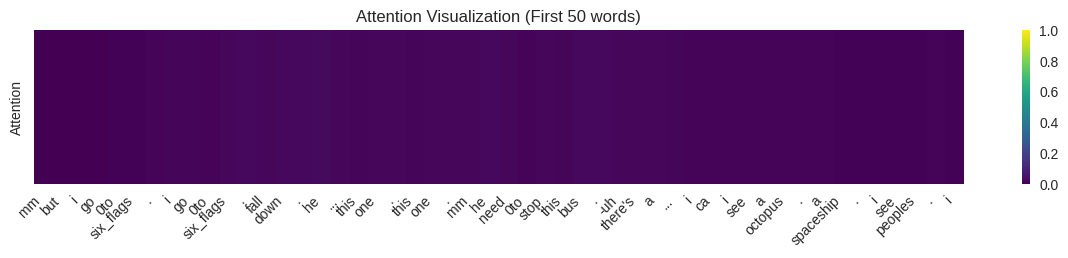


📊 Dev Set 오답 분석 중...

📊 Test Set 오답 분석 중...

총 오답 개수: 29 (Dev: 13, Test: 16)


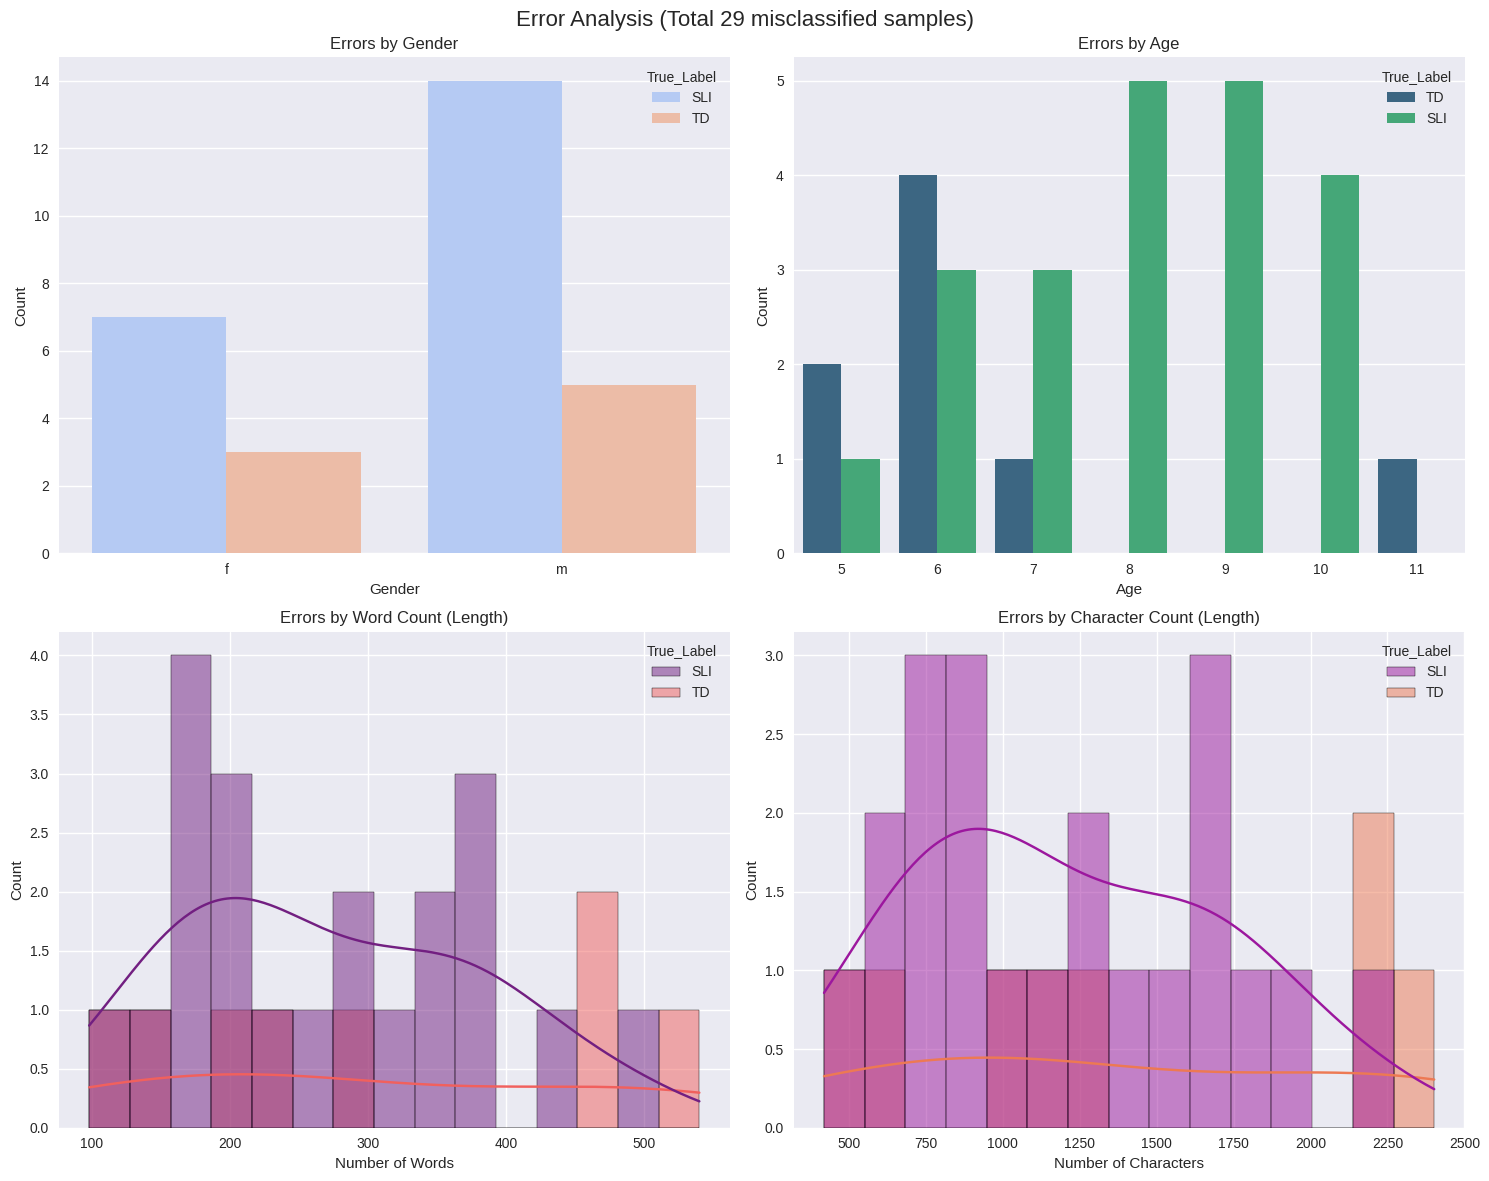


[상세 통계]

1. 성별 오답 수:
Gender
m    19
f    10
Name: count, dtype: int64

2. 연령별 오답 수:
Age
5     3
6     7
7     4
8     5
9     5
10    4
11    1
Name: count, dtype: int64

3. 평균 길이 통계 (오답 데이터):
       Word_Count   Char_Count
count   29.000000    29.000000
mean   282.310345  1261.896552
std    125.563900   570.021888
min     98.000000   419.000000
25%    179.000000   800.000000
50%    249.000000  1118.000000
75%    373.000000  1673.000000
max    540.000000  2402.000000


In [7]:
# ==========================================
# 1. 라이브러리 임포트
# ==========================================
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from utils import extract_utterances

# 한글 폰트 설정 (코랩 환경용)
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf
# (위 주석을 풀고 한번 실행 후 런타임을 재시작하면 한글이 깨지지 않습니다.
#  여기서는 영문 라벨을 사용하여 에러 없이 출력되도록 하겠습니다.)

plt.style.use('seaborn-v0_8')

# ==========================================
# 2. 어텐션 시각화 함수
# ==========================================
def visualize_attention(model, text, vocab):
    """
    특정 텍스트를 입력받아 모델의 어텐션 가중치를 시각화
    """
    model.set_train_flg(False) # 평가 모드

    # 전처리
    tokens = text.lower().split()
    if len(tokens) == 0: return

    ids = [vocab.get(w, vocab['<unk>']) for w in tokens]
    x_in = np.array(ids).reshape(1, -1) # Batch size 1

    # 모델 실행 (Attention 가중치 계산됨)
    _ = model.predict(x_in)

    # 가중치 가져오기 (1, T)
    # Attention 클래스 구현에 따라 shape이 다를 수 있어 확인 필요
    # 앞서 구현한 코드 기준: self.attention.attention_weights (N, T)
    weights = model.attention.attention_weights[0]

    # 시각화
    # 길이가 너무 길면 잘라서 보여줌 (가독성)
    view_len = min(len(tokens), 50)

    plt.figure(figsize=(15, 2))
    sns.heatmap(weights[:view_len].reshape(1, -1),
                xticklabels=tokens[:view_len],
                yticklabels=['Attention'],
                cmap='viridis',
                cbar=True,
                vmin=0, vmax=1)
    plt.title(f"Attention Visualization (First {view_len} words)")
    plt.xticks(rotation=45, ha='right')
    plt.show()

# 테스트: Dev 셋의 첫 번째 데이터로 시각화 해보기
print("🔍 어텐션 시각화 예시 (Dev Set Sample)")
dev_df = pd.read_csv('split/gillam_dev.csv')
sample_row = dev_df.iloc[0]
try:
    utts = extract_utterances(sample_row['filename'], ['CHI'])
    sample_text = " ".join([u.clean_text for u in utts])
    visualize_attention(model, sample_text, vocab)
except Exception as e:
    print(f"시각화 실패: {e}")


# ==========================================
# 3. 오답 데이터 상세 분석 함수
# ==========================================
def analyze_errors(model, df, vocab, dataset_name="Dev"):
    error_records = []
    model.set_train_flg(False)

    label_map = {'TD': 0, 'SLI': 1}
    inv_label_map = {0: 'TD', 1: 'SLI'}

    print(f"\n📊 {dataset_name} Set 오답 분석 중...")

    for idx, row in df.iterrows():
        try:
            # 데이터 로드 및 전처리
            utts = extract_utterances(row['filename'], ['CHI'])
            if not utts: continue

            text = " ".join([u.clean_text for u in utts]).lower()
            tokens = text.split()

            ids = [vocab.get(w, vocab['<unk>']) for w in tokens]
            x_in = np.array(ids).reshape(1, -1)

            # 예측
            score = model.predict(x_in)
            pred_idx = np.argmax(score, axis=1)[0]
            true_idx = label_map[row['group']]

            # 틀린 경우 저장
            if pred_idx != true_idx:
                error_records.append({
                    'Index': idx,
                    'Gender': row['gender'],
                    'Age': row['age'],
                    'True_Label': row['group'],
                    'Pred_Label': inv_label_map[pred_idx],
                    'Word_Count': len(tokens),
                    'Char_Count': len(text),
                    'Text': text[:50] + "..." # 일부만 저장
                })

        except Exception as e:
            continue

    return pd.DataFrame(error_records)

# 분석 실행
dev_errors = analyze_errors(model, pd.read_csv('split/gillam_dev.csv'), vocab, "Dev")
test_errors = analyze_errors(model, pd.read_csv('split/gillam_test.csv'), vocab, "Test")

# 데이터 합치기 (전체 오답 경향 파악)
all_errors = pd.concat([dev_errors, test_errors])
print(f"\n총 오답 개수: {len(all_errors)} (Dev: {len(dev_errors)}, Test: {len(test_errors)})")

# ==========================================
# 4. 오답 통계 시각화
# ==========================================
if len(all_errors) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    plt.suptitle(f"Error Analysis (Total {len(all_errors)} misclassified samples)", fontsize=16)

    # 1. 성별 오답 수 (Gender)
    sns.countplot(data=all_errors, x='Gender', hue='True_Label', ax=axes[0, 0], palette='coolwarm')
    axes[0, 0].set_title("Errors by Gender")
    axes[0, 0].set_ylabel("Count")

    # 2. 연령별 오답 수 (Age)
    sns.countplot(data=all_errors, x='Age', hue='True_Label', ax=axes[0, 1], palette='viridis')
    axes[0, 1].set_title("Errors by Age")
    axes[0, 1].set_ylabel("Count")

    # 3. 단어 수에 따른 오답 분포 (Word Count Histogram)
    sns.histplot(data=all_errors, x='Word_Count', hue='True_Label', kde=True, bins=15, ax=axes[1, 0], palette='magma')
    axes[1, 0].set_title("Errors by Word Count (Length)")
    axes[1, 0].set_xlabel("Number of Words")

    # 4. 글자 수에 따른 오답 분포 (Char Count Histogram)
    sns.histplot(data=all_errors, x='Char_Count', hue='True_Label', kde=True, bins=15, ax=axes[1, 1], palette='plasma')
    axes[1, 1].set_title("Errors by Character Count (Length)")
    axes[1, 1].set_xlabel("Number of Characters")

    plt.tight_layout()
    plt.show()

    # 통계 테이블 출력
    print("\n[상세 통계]")
    print("\n1. 성별 오답 수:")
    print(all_errors['Gender'].value_counts())

    print("\n2. 연령별 오답 수:")
    print(all_errors['Age'].value_counts().sort_index())

    print("\n3. 평균 길이 통계 (오답 데이터):")
    print(all_errors[['Word_Count', 'Char_Count']].describe())

else:
    print("🎉 축하합니다! 오답 데이터가 없습니다 (또는 데이터를 로드하지 못했습니다).")